Практическое задание:
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

**1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)**

**DATASET https://archive.ics.uci.edu/ml/datasets/Abalone**

Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. The number of rings is the value to predict: either as a continuous value or as a classification problem.

Name / Data Type / Measurement Unit / Description
-----------------------------
    - Sex / nominal / -- / M, F, and I (infant)
    - Length / continuous / mm / Longest shell measurement
    - Diameter / continuous / mm / perpendicular to length
    - Height / continuous / mm / with meat in shell
    - Whole weight / continuous / grams / whole abalone
    - Shucked weight / continuous / grams / weight of meat
    - Viscera weight / continuous / grams / gut weight (after bleeding)
    - Shell weight / continuous / grams / after being dried
    - Rings / integer / -- / +1.5 gives the age in years

In [1]:
# !pip install shap

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import shap

# load JS visualization code to notebook
shap.initjs()

In [3]:
df = pd.read_csv("abalone.csv", sep=',', names=['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'])
df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


**2. сделать обзорный анализ выбранного датасета**

**3. сделать feature engineering**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [5]:
df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [6]:
df['Rings'] = df['Rings'].astype('int8')

In [7]:
features = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
target = 'Rings'

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=42)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3132, 8), (1045, 8), (3132,), (1045,))

In [9]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [10]:
cat_cols = ['Sex']
cont_columns = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
final_transformers = list()


for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in cont_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))


feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

**4. обучить любой классификатор (какой вам нравится)**

In [11]:
model = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
model.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Sex',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Sex')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Sex'))])),
                                                ('Length',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Length')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('Diameter',
                                                 Pipeline(steps=[('selector',
                                    

**5. разобраться с SHAP и построить важности признаков для:**

    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%

In [12]:
model = xgb.train({"learning_rate": 0.01}, 
                      xgb.DMatrix(X_train[cont_columns], label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train[cont_columns])

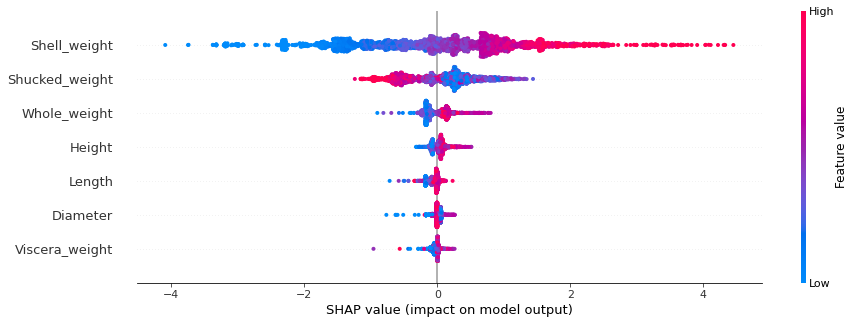

In [13]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train[cont_columns], plot_size=(14,5))

- Чем больше вес ракушки - тем старше особь. И наоборот.
- Чем больше вес мышц ракушки - тем особь моложе.
- Чем выше общий вес (ракушка и мышцы) - тем особь старше.

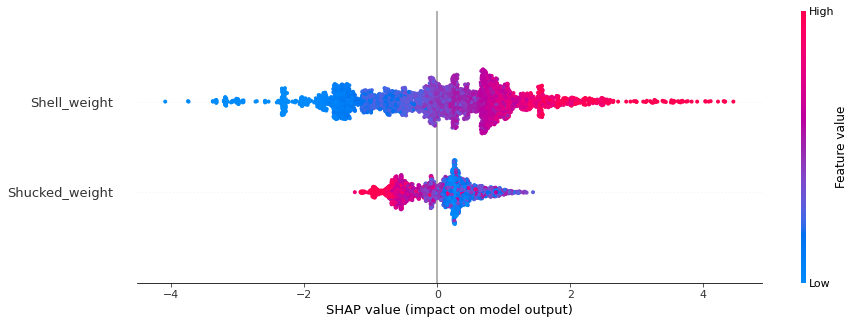

In [14]:
# summary_plot для топ 10%
shap.summary_plot(shap_values, X_train[cont_columns], max_display=2, plot_size=(14,5))

**6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат**

In [22]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[cont_columns].iloc[0,:])

In [23]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[2,:], X_train[cont_columns].iloc[2,:])

In [24]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[50,:], X_train[cont_columns].iloc[50,:])

Наибольший вклад вносят признаки - Whole_weight, Shucked_weight

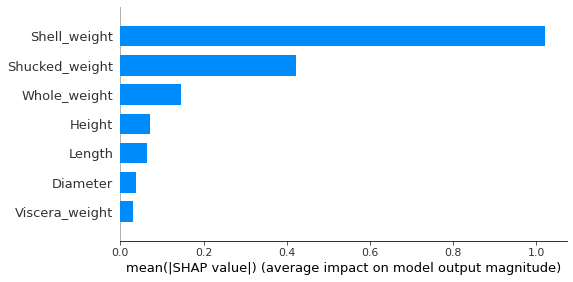

In [16]:
shap.summary_plot(shap_values, X_train[cont_columns], plot_type="bar")